Epoch 1/300, Train Loss: 0.9728537181736697, Validation Loss: 0.9447150656155178
Epoch 2/300, Train Loss: 0.9645069239153776, Validation Loss: 0.9364721462840125
Epoch 3/300, Train Loss: 0.9563787848527578, Validation Loss: 0.9283545301074073
Epoch 4/300, Train Loss: 0.9480612493651525, Validation Loss: 0.920479607014429
Epoch 5/300, Train Loss: 0.9401963450325649, Validation Loss: 0.9126894644328526
Epoch 6/300, Train Loss: 0.9323040748211309, Validation Loss: 0.9049842253563896
Epoch 7/300, Train Loss: 0.9247146482259094, Validation Loss: 0.8971445759137472
Epoch 8/300, Train Loss: 0.916884010757651, Validation Loss: 0.8894259333610535
Epoch 9/300, Train Loss: 0.9092528469282875, Validation Loss: 0.8815837237570021
Epoch 10/300, Train Loss: 0.9014382670461302, Validation Loss: 0.8737544720135038
Epoch 11/300, Train Loss: 0.8935432775357135, Validation Loss: 0.8655456238322787
Epoch 12/300, Train Loss: 0.8853864851102203, Validation Loss: 0.8570432000690036
Epoch 13/300, Train Loss: 0

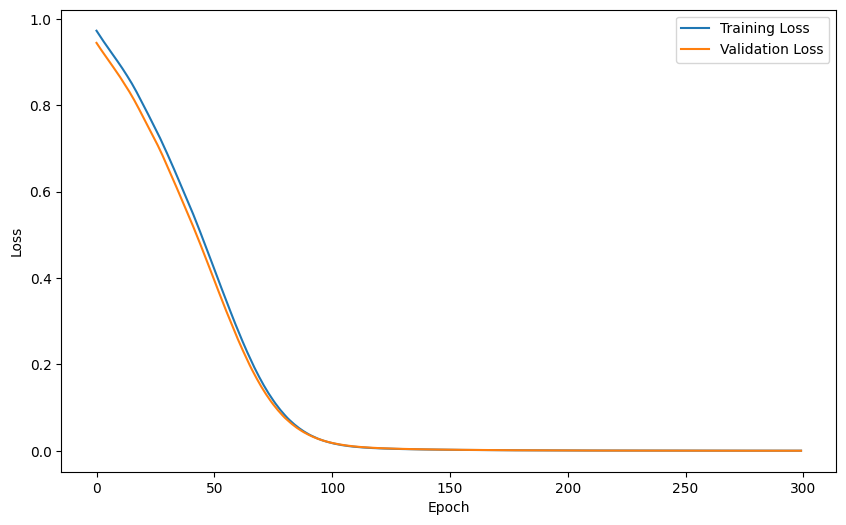

MAE: 0.07038237899541855, MSE: 0.0069635771214962006


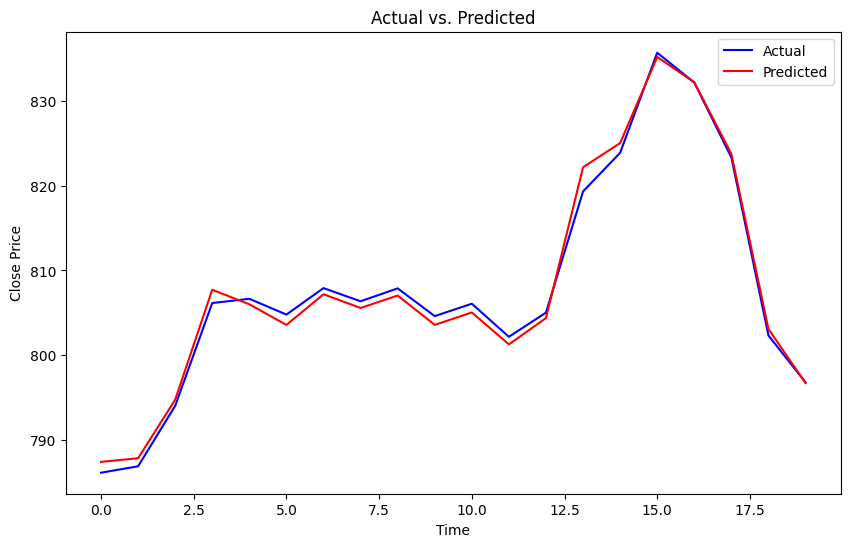

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.nn import Module, Sequential
from torch.nn import Linear, ReLU, LeakyReLU
from torch.optim import Adam
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and preprocess data
file_path_train="../20240312_Deep_Learning/NN_Regression/Google_Stock_Price/Google_Stock_Price_Train.csv"
file_path_test="../20240312_Deep_Learning/NN_Regression/Google_Stock_Price/Google_Stock_Price_Test.csv"
df_train = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)
df_train['Date'] = pd.to_datetime(df_train['Date'], format='%m/%d/%Y')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%m/%d/%Y')
df_train['Volume'] = df_train['Volume'].str.replace(',', '').astype(int)
df_test['Volume'] = df_test['Volume'].str.replace(',', '').astype(int)
X_train = df_train[['Open', 'High', 'Low', 'Close', 'Volume']].values
X_test = df_test[['Open', 'High', 'Low', 'Close', 'Volume']].values
y_train = df_train['Close'].values.reshape(-1, 1)  # Assuming you want to predict the 'Close' price
y_test = df_test['Close'].values.reshape(-1, 1)  # Assuming you want to predict the 'Close' price
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(y_train)
X_test_scaled = scaler.fit_transform(X_test)
y_test_scaled = scaler.fit_transform(y_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Define neural network architecture
class Neural_Network(nn.Module):
    def __init__(self, num_features: int, num_classes: int):
        super(Neural_Network, self).__init__()

        self.layer_1_neurons = 40
        self.layer_2_neurons = 20
        self.layer_3_neurons = 10
        self.output_neurons = 6  # Number of neurons in the last hidden layer

        self.fc_input = nn.Sequential(
            nn.Linear(num_features, self.layer_1_neurons),
            nn.LeakyReLU()
        )

        self.fc_l1 = nn.Sequential(
            nn.Linear(self.layer_1_neurons, self.layer_2_neurons),
            nn.LeakyReLU()
        )

        self.fc_l2 = nn.Sequential(
            nn.Linear(self.layer_2_neurons, self.layer_3_neurons),
            nn.LeakyReLU()
        )

        self.fc_output = nn.Sequential(
            nn.Linear(self.layer_3_neurons, num_classes),
            nn.Sigmoid()
        )

        # Linear regression layer
        self.linear_regression = nn.Linear(self.output_neurons + num_features, 1)

        self.optimizer = Adam(self.parameters(), lr=0.00005)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, x):
        x = self.fc_input(x)
        x = self.fc_l1(x)
        x = self.fc_l2(x)
        output_nn = self.fc_output(x)
        output_concat = torch.cat((output_nn, x), dim=1)  # Concatenate output with original features
        output_linear = self.linear_regression(output_concat)
        return output_linear

    def train_model(self, train_loader, val_loader, num_epochs=300):
        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            self.train()
            epoch_train_loss = 0.0
            for inputs, labels in train_loader:
                self.optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = self.loss_fn(outputs, labels)
                loss.backward()
                self.optimizer.step()
                epoch_train_loss += loss.item() * inputs.size(0)
            epoch_train_loss /= len(train_loader.dataset)
            train_losses.append(epoch_train_loss)

            # Validation loss
            self.eval()
            with torch.no_grad():
                epoch_val_loss = 0.0
                for inputs, labels in val_loader:
                    outputs = self.forward(inputs)
                    loss = self.loss_fn(outputs, labels)
                    epoch_val_loss += loss.item() * inputs.size(0)
                epoch_val_loss /= len(val_loader.dataset)
                val_losses.append(epoch_val_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

        # Plot loss curves
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate_model(self, X_test, y_test):
        self.eval()
        with torch.no_grad():
            predictions = self.forward(X_test)
            mae = mean_absolute_error(y_test.detach().numpy(), predictions.detach().numpy())
            mse = mean_squared_error(y_test.detach().numpy(), predictions.detach().numpy())
            print(f"MAE: {mae}, MSE: {mse}")
            return predictions

# Create DataLoader for both training and validation
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(X_train_tensor, y_train_tensor, test_size=0.2)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Create an instance of the neural network model
num_features = X_train_tensor.shape[1]
num_classes = 1  # Regression has one output
model = Neural_Network(num_features, num_classes)

# Train the model
model.train_model(train_loader, val_loader)

# Evaluate the model on the test set and print performance metrics
predictions = model.evaluate_model(X_test_tensor, y_test_tensor)

# Denormalize predictions
predictions_denormalized = scaler.inverse_transform(predictions.detach().numpy())
y_test_denormalized = scaler.inverse_transform(y_test_tensor.numpy())

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))

# Plotting the actual test data
plt.plot(y_test_denormalized, color='blue', label='Actual')

# Plotting the predicted data
plt.plot(predictions_denormalized, color='red', label='Predicted')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted')
plt.legend()
plt.show()
